In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

/var/folders/_3/g9t2yqjj403drcv7xdxch0v00000gn/T/ipykernel_83220/3943405390.py:26: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)         # Convert to integer coordinates


2953 2416
4032 3024


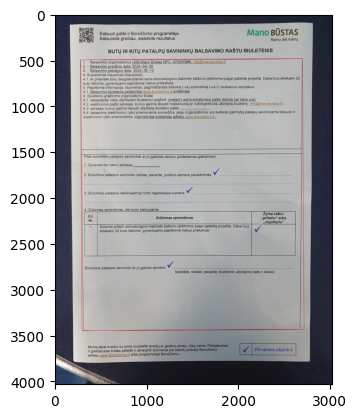

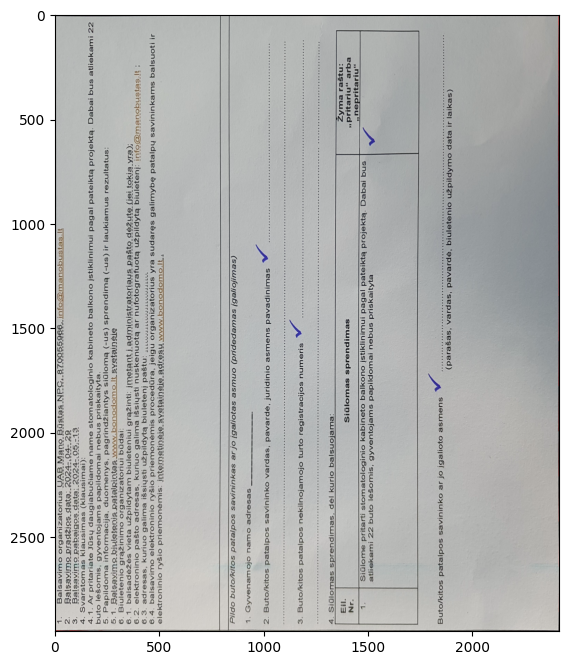

In [6]:
def find_and_crop_paper(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    paper_contour = None

    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            paper_contour = approx
            break

    image_area = img.shape[0] * img.shape[1]
    paper_contour_area = cv2.contourArea(paper_contour)
    if paper_contour_area < (1/3) * image_area:
        return img

    rect = cv2.minAreaRect(paper_contour)
    # Visualization (optional)
    box = cv2.boxPoints(rect)  # Get vertices of the rectangle
    box = np.int0(box)         # Convert to integer coordinates
    cv2.drawContours(image, [box], 0, (255, 0, 0), 2)
    width = int(min(rect[1]))
    height = int(max(rect[1]))
    img_height = img.shape[0]
    img_width = img.shape[1]
    print(height, width)
    print(img_height, img_width)
    plt.imshow(img, cmap='gray')
    plt.show()

    if paper_contour is not None:
        pts1 = np.float32(paper_contour.reshape(-1, 2))
        pts2 = np.float32([[0, 0], [0, height], [width, height], [width, 0]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(img, matrix, (width, height)) 

        return warped
    else:
        return img  # Return original image if no paper contour found

def sharpen(cropped_image):
    gaussian_blur = cv2.GaussianBlur(cropped_image, (5,5), 0)  # Kernel size (5, 5) is common
    unsharp_mask = cv2.addWeighted(cropped_image, 1.5, gaussian_blur, -0.5, 0)
    return unsharp_mask

image = cv2.imread('../forms/form.png')
cropped_image = find_and_crop_paper(image)
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray')
plt.show()